# Tutorial 1: 2D flow past a cylinder
## flowTorch workshop 29.09.2025 - 02.10.2025

### Outline
1. Loading the data
2. Computing a metric and adding geometries
3. Creating a new mesh
4. Exporting the data
5. Optional: performing an SVD
6. Using the `DataLoader`
7. References and further material

In this introductory tutorial, we will use $S^3$ for a flow past a cylinder at $Re = 100$. You can find the numerical setup in the [flow_data](https://github.com/AndreWeiner/flow_data) repository.
This tutorial uses `OpenFOAM` as CFD tool to generate the data, however, $S^3$ works for other data formats as well.

In general, $S^3$ expects three things:
1. a point cloud representing the corrdinates of the cell centers
2. a value (metric) associated with each cell center, indicating the importance of that cell
3. a stopping criterion, e.g. the max. number of cells or a min. threshold for approximating the metric

## 1. Loading the data
First we load and inspect our simulation data. Therefore, $S^3$ implicitly uses the [flowTorch](https://github.com/AndreWeiner/flowtorch/tree/aweiner) package, which provides a variety of APIs for loading CFD data. Depending on your data structure, you can use the best-suited dataloader within `flowTorch.data` directly.

In [1]:
import sys
import torch as pt
from os.path import join
from os import environ, system

environ["sparseSpatialSampling"] = ".."
sys.path.insert(0, environ["sparseSpatialSampling"])

from sparseSpatialSampling.export import ExportData
from sparseSpatialSampling.geometry import CubeGeometry, SphereGeometry
from sparseSpatialSampling.sparse_spatial_sampling import SparseSpatialSampling
from sparseSpatialSampling.utils import load_foam_data, export_openfoam_fields

Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.


In [2]:
# define load paths to the CFD data
load_path = join("..", "..", "flow_data", "run", "cylinder_2D_Re100")

# here we use the approximated metric field as stopping criterion
# how much of the metric within the original grid should be captured at least
min_metric = 0.75

# define the path to where we want to save the results and the name of the file
save_path = join("..", "run", "tutorials", "tutorial_1")
save_name = "cylinder2D_metric_{:.2f}".format(min_metric)

In [3]:
# now we can load the data. Since we used OpenFOAM, we can use the load_foam_data function provided by S^3.
# Otherwise, we have to use flowtorch dataloaders directly, refer to the flowtorch documentation

# define boundaries of the masked domain for the cylinder, here we want to load the full domain
bounds = [[0, 0], [2.2, 0.41]]  # [[xmin, ymin], [xmax, ymax]]

# load the CFD data, we want to compute the metric based on the velocity in the quasi-steady state, so omit the first 4 seconds
field, coord, _, write_times = load_foam_data(load_path, bounds, field_name="U", t_start=4, scalar=False)

# display some information about the grid
print(f"Grid size: {field.shape[0]} cells.")
print(f"Found {field.shape[-1]} snapshots.")

[2025-08-14 09:47:44] INFO     Loading precomputed cell centers and volumes from processor0/constant
[2025-08-14 09:47:44] INFO     Loading precomputed cell centers and volumes from processor1/constant


Grid size: 9800 cells.
Found 3001 snapshots.


we can visualize the flow field and the grid in paraview:

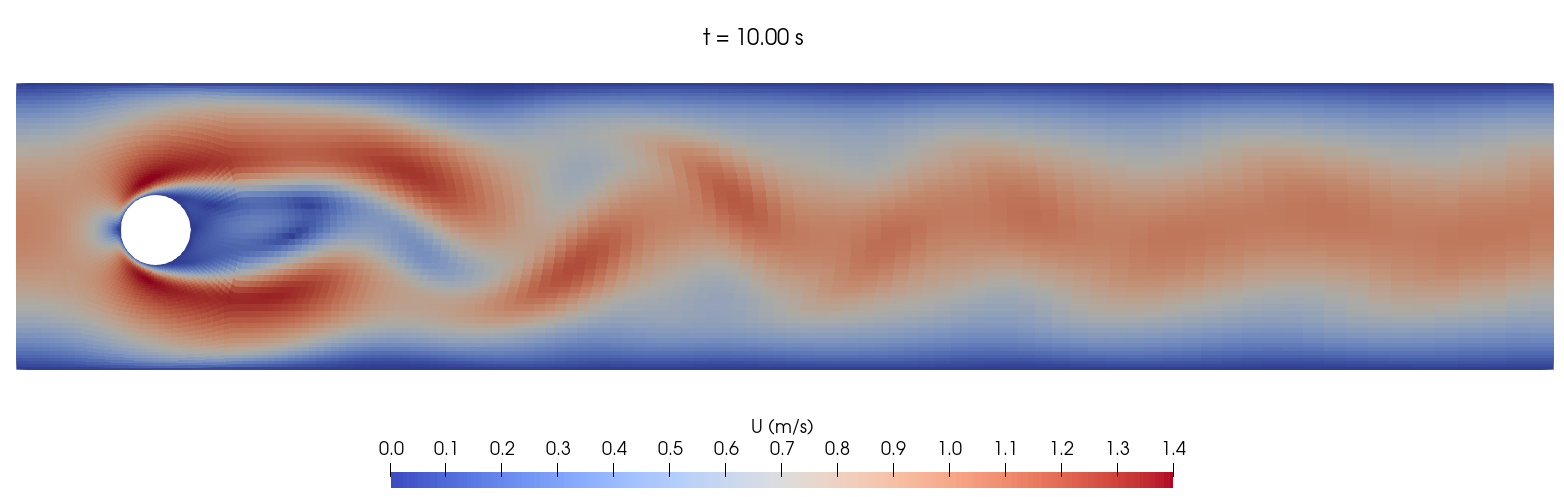
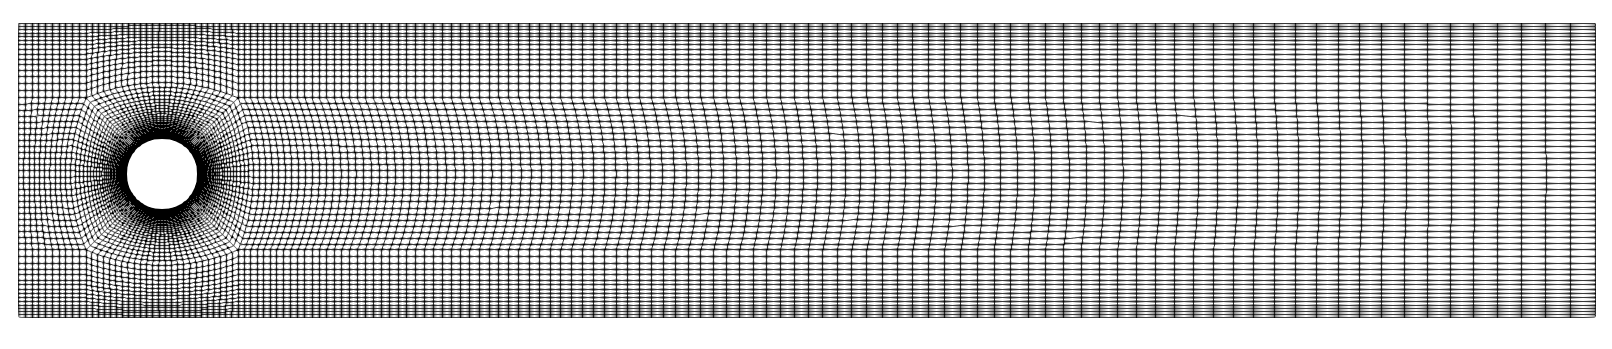


Since the grid is already quite coarse, we don't expect a significant data reduction when using $S^3$.

## 2. Computing a metric and adding geometries

In [4]:
# now we compute a metric. in this case, we just use the temporal mean of the abs. velocity vector
metric = pt.mean(field.abs().sum(1), 1)

# create geometry objects for the domain and the cylinder
# we don't want to refine the domain boundaries, so keep all the optional arguments as default
domain = CubeGeometry("domain", True, bounds[0], bounds[1])

# define the properties of the cylinder
position = [0.2, 0.2]
radius = 0.05

# we want to refine the cylinder surface, so we set refine=True
# by default this refines the cylinder with the max. level encountered at the geoemtry. However, we can also increase the
# resolution of the cylinder by passing a min_refinement_level
geometry = SphereGeometry("cylinder", False, position, radius, refine=True, min_refinement_level=9)

# create a S^3 instance, since this is a quite small case, we set the number of CPUs (n_jobs) to 4. 
# Further, we want to stop the refinement process based on the approximation of the metric, so we have to pass the threshold min_metric as well
s_cube = SparseSpatialSampling(coord, metric, [domain, geometry], save_path, save_name, "cylinder2D", min_metric=min_metric, n_jobs=4)

[2025-08-14 09:47:56] INFO     
	Selected settings:
		_pre_select          :	False
		_n_jobs              :	4
		_max_delta_level     :	False
		_geometry            :	['domain', 'cylinder']
		_min_metric          :	0.75
		_n_cells_max         :	None
		_min_level           :	5
		_cells_per_iter_start:	9
		_cells_per_iter_end  :	9
		_cells_per_iter      :	9
		_cells_per_iter_last :	1000000000.0
		_reach_at_least      :	0.75
		_n_dimensions        :	2
		_n_cells_orig        :	9800
		_relTol              :	0.001


In [5]:
# we can also check out the available geometry object classes
from sparseSpatialSampling.sparse_spatial_sampling import list_geometries
list_geometries()

[2025-08-14 09:47:56] INFO     
	Available geometry objects:
	---------------------------
		- CubeGeometry          : implements a class for using rectangles (2D) or cubes (3D)
		- CylinderGeometry3D    : implements a class for using cylinders (3D)
		- GeometryCoordinates2D : implements a class for using 2D coordinates
		- GeometrySTL3D         : implements a class for using an STL file (3D)
		- SphereGeometry        : implements a class for using circles (2D) or spheres (3D)

	For a more detailed description checkout the respective geometry object classes.


## 3. Creating a new mesh
Now we are ready to create a new grid using $S^3$. This can be achieved by simply calling the `execute_grid_generation()` method:

In [6]:
# execute the mesh generation with S^3
s_cube.execute_grid_generation()

[2025-08-14 09:47:56] INFO     Starting refinement:
	Starting iteration no. 0, N_cells = 1
	Starting iteration no. 1, N_cells = 4
	Starting iteration no. 2, N_cells = 8
	Starting iteration no. 3, N_cells = 16
	Starting iteration no. 4, N_cells = 64
[2025-08-14 09:48:01] INFO     Finished uniform refinement.
[2025-08-14 09:48:01] INFO     Starting adaptive refinement.
	Starting iteration no. 0, captured metric: 13.66 %, N_cells = 256
	Starting iteration no. 1, captured metric: 14.53 %, N_cells = 281
	Starting iteration no. 2, captured metric: 15.1 %, N_cells = 308
	Starting iteration no. 3, captured metric: 15.4 %, N_cells = 335
	Starting iteration no. 4, captured metric: 16.34 %, N_cells = 362
	Starting iteration no. 5, captured metric: 16.51 %, N_cells = 389
	Starting iteration no. 6, captured metric: 16.67 %, N_cells = 416
	Starting iteration no. 7, captured metric: 16.92 %, N_cells = 443
	Starting iteration no. 8, captured metric: 17.13 %, N_cells = 470
	Starting iteration no. 9, ca

Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.
Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.
Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.
Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.


[2025-08-14 09:48:14] INFO     Finished refinement in 17.2644 s 
								(160 iterations).
								Time for uniform refinement: 4.8455 s
								Time for adaptive refinement: 7.5019 s
								Time for geometry refinement: 0.2912 s
								Time for renumbering the final mesh: 4.6108 s
								
                                    Number of cells: 4455
                                    Minimum ref. level: 6
                                    Maximum ref. level: 9
                                    Captured metric of original grid: 61.46 %
                  


As we notice from the output, we don't reach the specified metric of `min_metric = 0.75`, but the refinement process stops at around $61.46\%$.
The reason for that is another stopping criterion, which aborts the refinement process based on the relative improvement between two consecutive iterations. This parameter `relTol` is by default set to `relTol = 0.001`.  We can disable it either by setting it to zero, or by setting the parameter `reach_at_least` to one. `reach_at_least` sets the threshols when to activate the `relTol` stopping criterion and defaults to `reach_at_least=0.75`, meaning that we have to approximate the metric by $75\%$ before the `relTol` stopping criterion is activated. However, this will increase the required runtime:

In [7]:
# omit the relTol stopping criterion, change cell type if you want to test this
# s_cube = SparseSpatialSampling(coord, metric, [domain, geometry], save_path, save_name, "cylinder2D", min_metric=min_metric, n_jobs=4,
#                                relTol=0) 
# s_cube.execute_grid_generation()

$S^3$ will create two output files:

1. `mesh_info_<save_name>.pt`
2. `s_cube_<save_name>.pt`

The first file contains statistics about the mesh generation and the final mesh while the latter contains the `s_cube` object itself. This is useful in case we want to carry out the grid generation process independently from the export of the flow fields. 
In this case, instead of executing the grid generation aggain, we can simply load the `s_cube` object as:

`s_cube = pt.load("s_cube_<save_name>.pt", weights_only=False)`

and then continue with the next section.

## 4. Exporting the data

In [8]:
# create export instance, export all fields into the same HFD5 file and create single XDMF from it
export = ExportData(s_cube)

# by default, solutions are exported at the cells center as well as the cell vertices, yielding two fields for each exported variable.
# To avoid this, we can set the parameter interpolate_at_vertices to False. Now only the cell-centered solution is exported
export = ExportData(s_cube, interpolate_at_vertices=False)

# export all available write times for fields available
export_openfoam_fields(export, load_path, bounds)

[2025-08-14 09:48:14] INFO     Exporting batch 1 / 1
[2025-08-14 09:48:14] INFO     Loading precomputed cell centers and volumes from processor0/constant
[2025-08-14 09:48:14] INFO     Loading precomputed cell centers and volumes from processor1/constant
[2025-08-14 09:49:57] INFO     Starting interpolation and export of field U.
[2025-08-14 09:50:05] INFO     Writing HDF5 file for field U.
[2025-08-14 09:50:13] INFO     Writing XDMF file for file cylinder2D_metric_0.75.h5
[2025-08-14 09:50:14] INFO     Finished export of field U in 120.765s.
[2025-08-14 09:50:14] INFO     Exporting batch 1 / 1
[2025-08-14 09:50:15] INFO     Loading precomputed cell centers and volumes from processor0/constant
[2025-08-14 09:50:15] INFO     Loading precomputed cell centers and volumes from processor1/constant
[2025-08-14 09:50:51] INFO     Writing XDMF file for file cylinder2D_metric_0.75.h5
[2025-08-14 09:50:53] INFO     Finished export of field p in 38.6s.


In [9]:
# Note: executing this cell will overwrite the files containing the exported fields in the previous cell
# we have to instantiate another export object since otherwise this leads to issues with HDF5
export = ExportData(s_cube, interpolate_at_vertices=False)

# alternatively, we can export data available at only certain time steps, but we need to assure that we don't get any round-off issues.
# so we specify the precision first
export.write_times = ["{:.3f}".format(i.item()) for i in pt.arange(4, 10, 0.001)]

# now export the velocity field, since we used that to compute our metric, we don't need to re-load it
export.export(coord, field, "U")

# now we can load and export the pressure field
field, _, _, _ = load_foam_data(load_path, bounds, t_start=4)

# export() expects a field of [N_cells, N_dimensions, N_snapshots], so for a scalar field we have to add a dimension
export.export(coord, field.unsqueeze(1), "p")

[2025-08-14 09:50:53] INFO     Starting interpolation and export of field U.
[2025-08-14 09:50:56] INFO     Writing HDF5 file for field U.
[2025-08-14 09:51:00] INFO     Writing XDMF file for file cylinder2D_metric_0.75.h5
[2025-08-14 09:51:01] INFO     Finished export of field U in 7.802s.
[2025-08-14 09:51:01] INFO     Loading precomputed cell centers and volumes from processor0/constant
[2025-08-14 09:51:01] INFO     Loading precomputed cell centers and volumes from processor1/constant
[2025-08-14 09:51:08] INFO     Writing XDMF file for file cylinder2D_metric_0.75.h5
[2025-08-14 09:51:09] INFO     Finished export of field p in 8.316s.


This creates two new files:

1. `<save_name>.h5` which contains all the exported flow fields along with the metric and cell levels
2.  `<save_name>.xdmf` which is a markdown file for loading the results into paraview

we can now take a look at the grid, metric and flow field by loading the `cylinder2D_metric_0.75.xdmf` into paraview. When opening the `XDMF` file in Paraview, it is important to select the `Xdmf3ReaderS`, all other readers will lead to an incorrect assignment of the values to the respective cells. Once we have loaded the file, we can visualize the different quantitites:

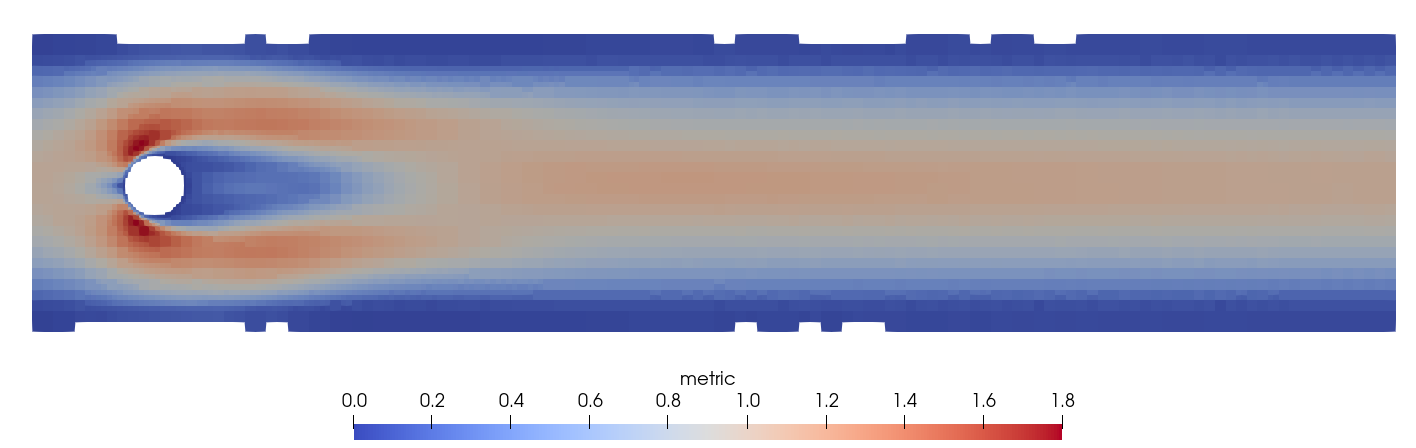
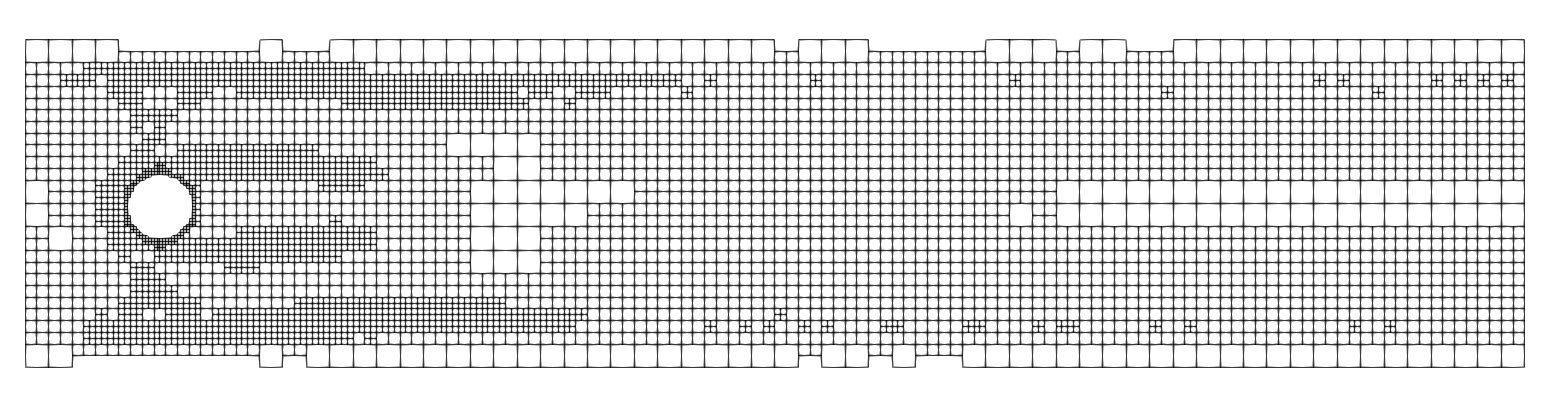
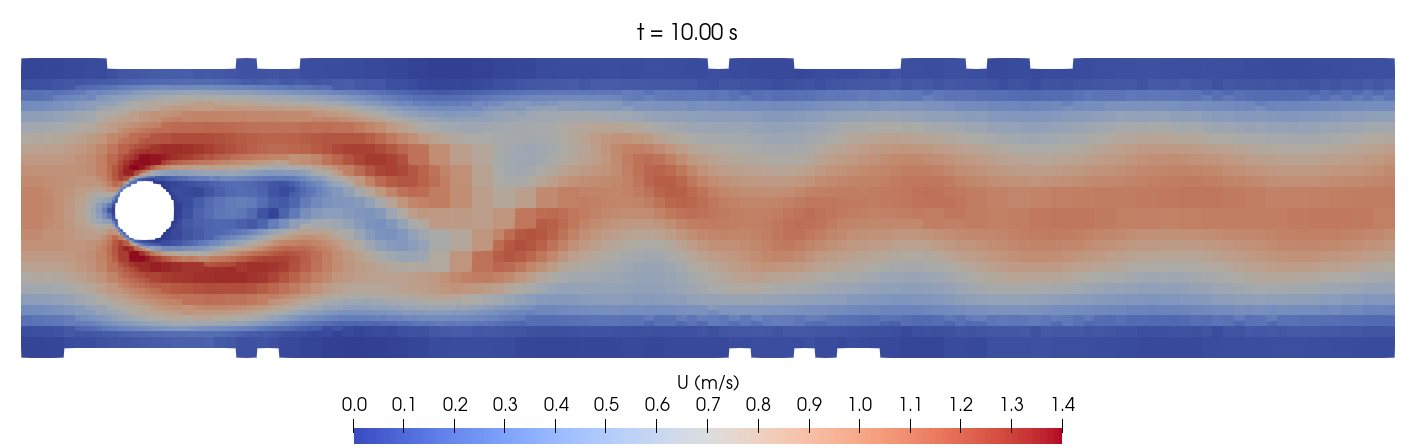

## 5. Optional: performing an SVD

We can further perform an SVD for analysing flow patterns. The results of the SVD are saved in separate `HDF5`and `XDMF`files. It is important to note that the SVD is computed separately for each specified field.

In [10]:
from sparseSpatialSampling.utils import write_svd_s_cube_to_file

# compute the SVD on grid generated by S^3 separately for each field and export the results to HDF5 & XDMF
# make sure to skip the initial transient pahse
write_svd_s_cube_to_file(["p", "U"], save_path, save_name, False, 50, rank=int(1e5), t_start=4)

[2025-08-14 09:51:09] INFO     Performing SVD for field p.
[2025-08-14 09:51:15] INFO     Writing XDMF file for file cylinder2D_metric_0.75_p_svd.h5
[2025-08-14 09:51:15] INFO     Performing SVD for field U.
[2025-08-14 09:51:19] INFO     Writing XDMF file for file cylinder2D_metric_0.75_U_svd.h5


## 6. Using the `Dataloader` (`flowtorch.SCUBEDataloader`)

We can load flow fields or other results from files generated by $S^3$ using the `Dataloader`class:

In [11]:
from flowtorch.data import SCUBEDataloader
from sparseSpatialSampling.data import Dataloader

# we can use the dataloder to load and post-process Scube data
dataloader = Dataloader(save_path, f"{save_name}.h5")

# alternatively, we can use the SCUBEDataloader within flowTorch
dataloader = SCUBEDataloader(save_path, f"{save_name}.h5")

# we can now use the dataloader for post-processing etc.
print(f"Number of cells: {dataloader.vertices.size(0)}")
print(f"Field names at t = {dataloader.write_times[0]}s: {dataloader.field_names[dataloader.write_times[0]]}")

Number of cells: 4455
Field names at t = 4.000s: ['U', 'p']


Note that the results from SVD can't be loaded with the`Dataloader`. For now, you can find an example on how to do that in: 

`post_processing/compare_svd_results_s_cube.py`

## 7. References and further material

You can find more examples and post-processing utilities in the `examples` and `post_processing` directories, respectively. There will be more tutorials added in the future.

This completes the first tutorial. In the next tutorial we will learn how to deal with other data formats, such as HDF5, and other geometry representations.